<a href="https://colab.research.google.com/github/NickyGuants/mnist_from_scratch/blob/main/Mnist_tf_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [47]:
from tensorflow.keras.datasets import mnist

Load and inspect the data

In [48]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [49]:
train_images.shape

(60000, 28, 28)

In [50]:
train_labels.shape

(60000,)

In [51]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [52]:
test_images.shape

(10000, 28, 28)

In [53]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

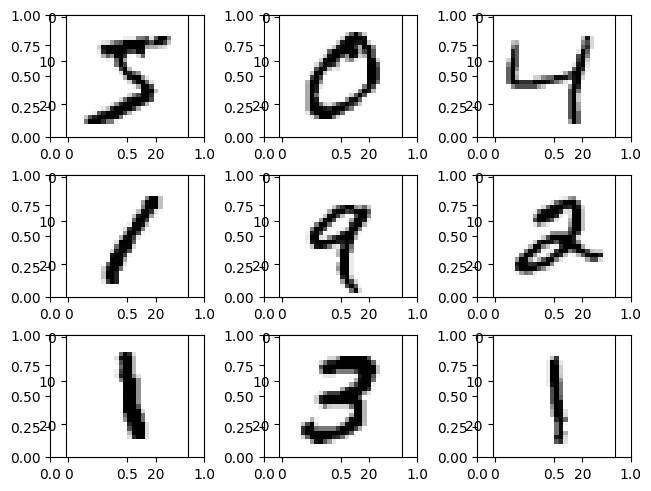

In [54]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3,3, squeeze=False)
for i in range(1,9+1):
  idx = i-1
  digit = train_images[idx]
  fig.add_subplot(3, 3, i)
  plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

Creating the Model

In [55]:
# A single layer in the network
class Dense:
  def __init__(self, input_size, output_size, activation):
    self.activation = activation

    #Weight matrix, W of shape (input_size, output_size) with random inital values
    w_shape = (input_size, output_size)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
    self.W = tf.Variable(w_initial_value)

    #Bias Vector, b of shape (output_size,) with zero inital values
    b_shape = (output_size,)
    b_inital_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_inital_value)

  # Forwad pass where out = activation(dot(W, input)+b)
  def __call__(self, inputs):
    return self.activation(tf.matmul(inputs, self.W) + self.b)

  @property
  def weights(self):
    return [self.W, self.b]


In [56]:
#A sequential class to hold multiple layers
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:
      weights += layer.weights
    return weights

In [57]:
#Create batches of data
import math

class BatchGenerator:
  def __init__(self, images, labels, batch_size=128):
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil(len(images) / batch_size)

  def next(self):
    images = self.images[self.index:self.index + self.batch_size]
    labels = self.labels[self.index:self.index + self.batch_size]
    self.index+=self.batch_size
    return images, labels

In [58]:
def train_one_loop(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:
    preds = model(images_batch)
    per_sample_loss = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, preds)
    average_loss = tf.reduce_mean(per_sample_loss)
  grads = tape.gradient(average_loss, model.weights)
  update_weights(grads, model.weights)
  return average_loss

In [59]:
# Weights update with no optmizer
learning_rate = 1e-3
def update_weights(gradients, weights):
  for g, w in zip(gradients,weights):
    w.assign_sub(g * learning_rate)

#Weights update with Optmizers
from tensorflow.keras import optimizers
optimizer = optimizers.SGD(learning_rate)
def update_weights_optm(grads, weights):
  optimizer.apply_gradients(zip(grads, weights))

In [60]:
#Full training loop
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f"Epoch {epoch_counter}")
    batch = BatchGenerator(images, labels)
    for batch_counter in range(batch.num_batches):
      images_batch, labels_batch = batch.next()
      loss = train_one_loop(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f"Loss at batch {batch_counter}: {loss: .2f}")

In [61]:
model = Sequential([
    Dense(input_size=28*28, output_size=512, activation=tf.nn.relu),
    Dense(input_size=512, output_size=10, activation=tf.nn.softmax)
])

In [62]:
len(model.weights)

4

In [63]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32") / 255

In [64]:
fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
Loss at batch 0:  5.55
Loss at batch 100:  2.23
Loss at batch 200:  2.19
Loss at batch 300:  2.08
Loss at batch 400:  2.22
Epoch 1
Loss at batch 0:  1.89
Loss at batch 100:  1.86
Loss at batch 200:  1.81
Loss at batch 300:  1.69
Loss at batch 400:  1.82
Epoch 2
Loss at batch 0:  1.56
Loss at batch 100:  1.55
Loss at batch 200:  1.49
Loss at batch 300:  1.40
Loss at batch 400:  1.50
Epoch 3
Loss at batch 0:  1.30
Loss at batch 100:  1.32
Loss at batch 200:  1.23
Loss at batch 300:  1.19
Loss at batch 400:  1.27
Epoch 4
Loss at batch 0:  1.11
Loss at batch 100:  1.14
Loss at batch 200:  1.03
Loss at batch 300:  1.03
Loss at batch 400:  1.11
Epoch 5
Loss at batch 0:  0.97
Loss at batch 100:  1.01
Loss at batch 200:  0.90
Loss at batch 300:  0.92
Loss at batch 400:  0.99
Epoch 6
Loss at batch 0:  0.86
Loss at batch 100:  0.90
Loss at batch 200:  0.80
Loss at batch 300:  0.83
Loss at batch 400:  0.90
Epoch 7
Loss at batch 0:  0.78
Loss at batch 100:  0.82
Loss at batch 200:  0.72
Lo

In [65]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"Accuracy: {matches.mean() : .2f}")

Accuracy:  0.82
